# Recommender system using NMF

In this notebook we will use the Non-negative Matrix Factorization (NMF) algorithm to build a recommender system for movies. The dataset we will use is the [MovieLens 1M dataset](https://grouplens.org/datasets/movielens/1m/). We are going to adress some shortcomings of the matrix factorization and propose a solution to them.

## Setup

In [41]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
plt.style.use('ggplot')
sns.set_style('dark')
sns.set_palette('muted', color_codes=True)  
random_seed = 0
np.random.seed(random_seed)

In [44]:
os.environ['KAGGLE_CONFIG_DIR'] = '.kaggle\kaggle.json'
!kaggle datasets download -d odedgolden/movielens-1m-dataset -p data\movielens
with zipfile.ZipFile('data/movielens/movielens-1m-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data/movielens')

<>:1: SyntaxWarning: invalid escape sequence '\k'
<>:1: SyntaxWarning: invalid escape sequence '\k'
C:\Users\cozie\AppData\Local\Temp\ipykernel_32708\178783147.py:1: SyntaxWarning: invalid escape sequence '\k'
  os.environ['KAGGLE_CONFIG_DIR'] = '.kaggle\kaggle.json'
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\cozie\Coding\BBC News Classification\BBC-News-Classification\venv\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\cozie\Coding\BBC News Classification\BBC-News-Classification\venv\Lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\cozie\Coding\BBC News Classification\BBC-News-Classification\venv\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located i

In [45]:
movies = pd.read_csv('data/movielens/movies.dat', sep='::', header=None,
                     names=['movie_id', 'title', 'genres'], encoding='latin-1', engine='python')          
ratings = pd.read_csv('data/movielens/ratings.dat', sep='::', header=None,
                      names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin-1', engine='python')
users = pd.read_csv('data/movielens/users.dat', sep='::', header=None,
                     names=['user_id', 'sex', 'age', 'occupation', 'zipcode'], encoding='latin-1', engine='python') 

## EDA

We have three dataframes: movies, users and ratings. 

### Movies

The movies dataframe contains the movieId, title and genres of 3883 movies

In [46]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


Let's create a new column called year which contains the year of the movie release. Also we are going to clean the genres column by removing the pipe character and splitting the genres into a list. 

In [47]:
movies['year'] = movies['title'].str.extract(r'.*\((.*)\).*', expand=True)
movies['year'] = pd.to_datetime(movies['year'], format='%Y')
movies['year'] = movies['year'].dt.year
movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '', regex=True)  
movies['genres'] = movies['genres'].str.split('|') 
movies              


<>:4: SyntaxWarning: invalid escape sequence '\('
<>:4: SyntaxWarning: invalid escape sequence '\('
C:\Users\cozie\AppData\Local\Temp\ipykernel_32708\1441163417.py:4: SyntaxWarning: invalid escape sequence '\('
  movies['title'] = movies['title'].str.replace('(\(\d\d\d\d\))', '', regex=True)


,movie_id,title,genres,year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000
3879,3949,Requiem for a Dream,[Drama],2000
3880,3950,Tigerland,[Drama],2000
3881,3951,Two Family House,[Drama],2000


Let's explore the number of movies released per year.

Text(0.5, 0, 'Year')

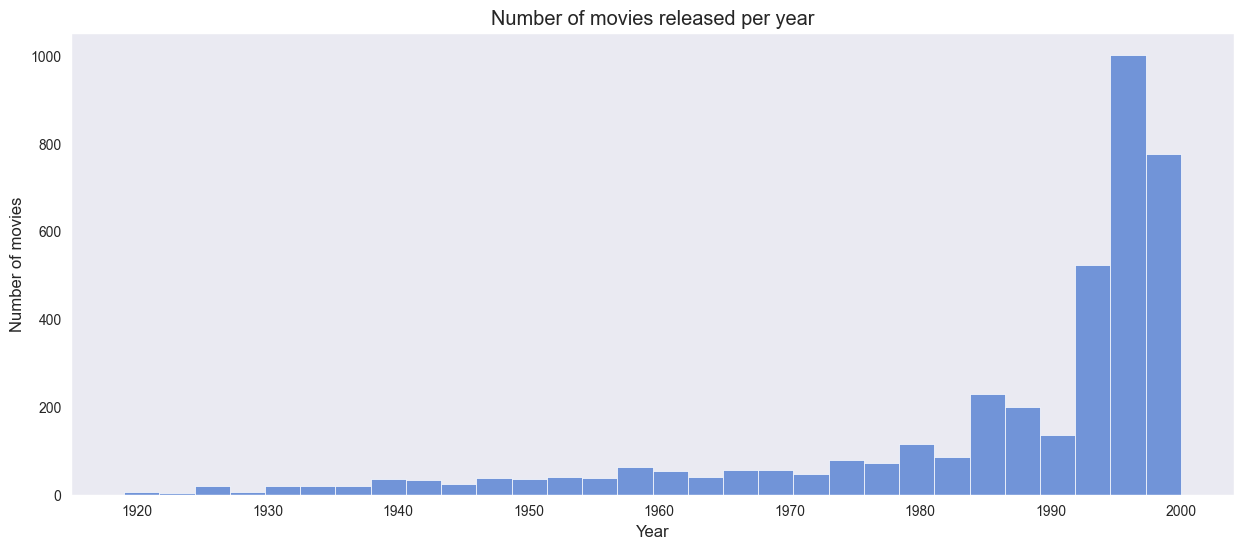

In [48]:
plt.figure(figsize=(15, 6))     
sns.histplot(movies['year'], bins=30, kde=False)                
plt.title('Number of movies released per year')             
plt.ylabel('Number of movies')
plt.xlabel('Year')  
    

The majority of the movies were released between 1990 and 2000.
Now let's explore the genres.

In [49]:
unique_genres = set()   
for movie_genres in movies['genres'].values:
    unique_genres.update(movie_genres)      
tmp = movies['genres'].str.join('|').str.get_dummies() 
movie_genres = pd.concat([movies[['movie_id', 'year']], tmp], axis=1)
movie_genres

,movie_id,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,2000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,3949,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,3950,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,3951,2000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


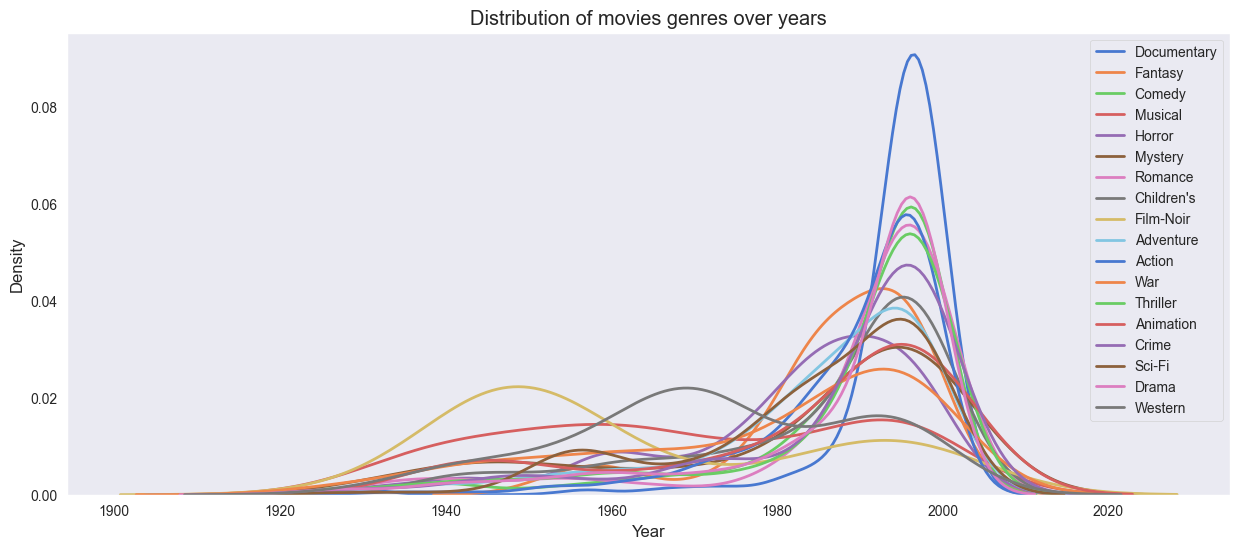

In [50]:
plt.figure(figsize=(15, 6))
for genre in unique_genres:
    tmp = movie_genres[movie_genres[genre] == 1]
    sns.kdeplot(tmp['year'], label=genre, linewidth=2)
plt.title('Distribution of movies genres over years')       
plt.ylabel('Density')
plt.xlabel('Year')  
plt.legend()  

There is a significant number of documentaries released around 1990. Some interesting findings are the number of sci-fi movies released around 1980 and the decline of children movies around 1960.

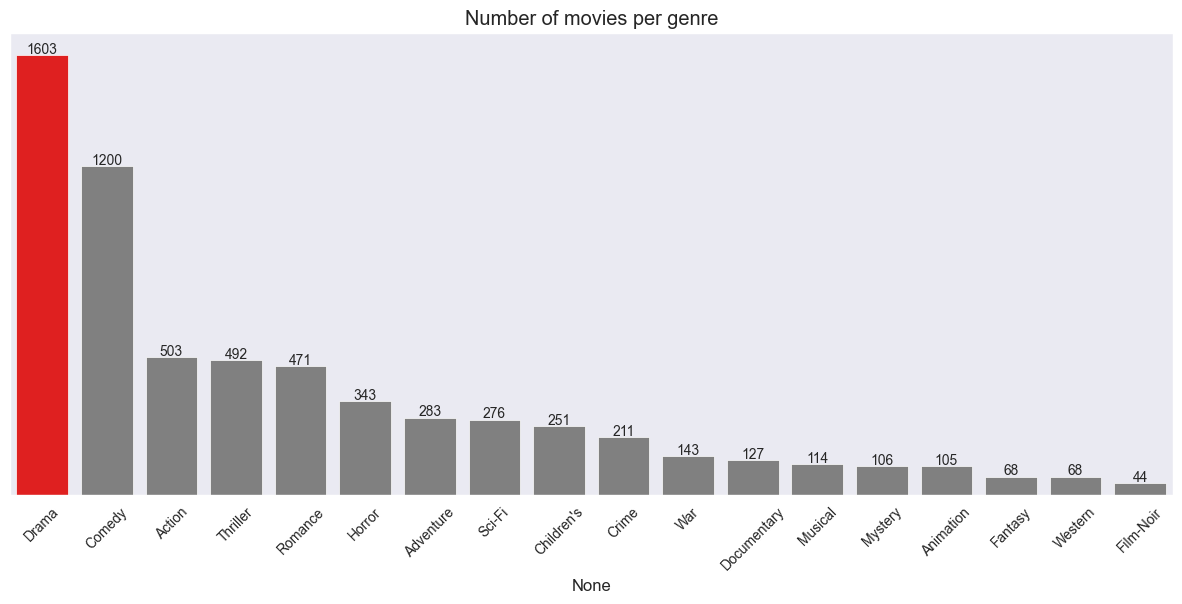

In [51]:
unique_genres = list(unique_genres)
tmp = movie_genres[unique_genres].sum(axis=0).sort_values(ascending=False)
colors = ['gray' if (x < max(tmp.values)) else 'red' for x in tmp.values]
plt.figure(figsize=(15, 6))
fig = sns.barplot(x=tmp.index, y=tmp.values, palette=colors)
plt.title('Number of movies per genre')
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+5,s='{:.0f}'.format(height), ha='center')
plt.tick_params(labelbottom=True, labelleft=False)
plt.xticks(rotation=45);



Most movies are classified as drama, comedy and action.

### Users

The users dataframe contains the user_id, sex, age and zipcode of 6040 users.

In [52]:
users

,user_id,sex,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


Let's explore the age distribution of the users.

<Axes: xlabel='age', ylabel='Count'>

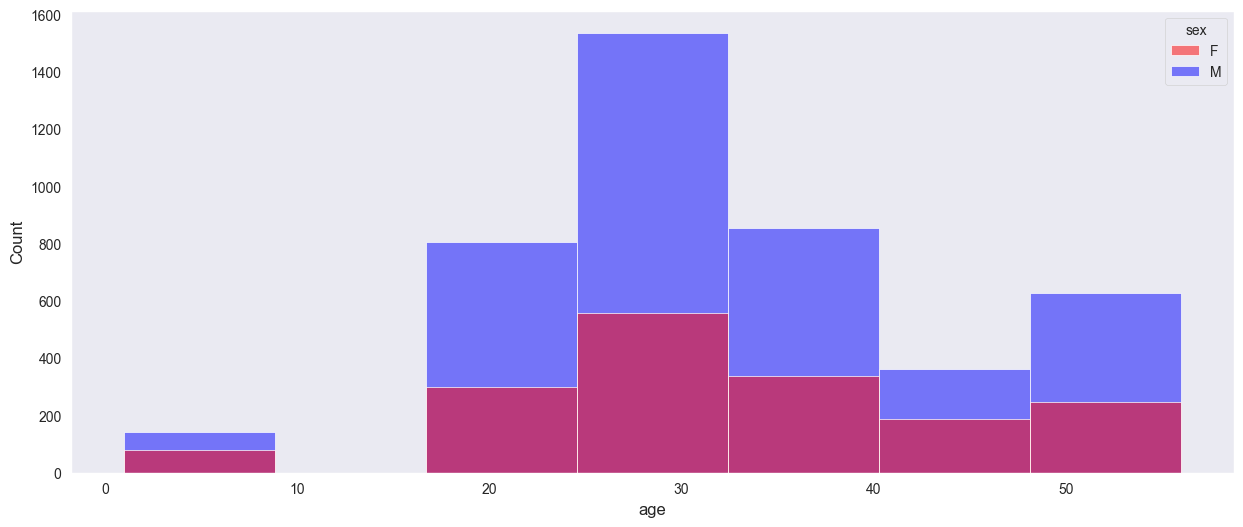

In [53]:
plt.figure(figsize=(15, 6))
sns.histplot(data=users, x='age', bins=7, kde=False, hue='sex', palette=['red','blue'])

Most users are between 18 and 50 years old. Also there is a significant amount of users who identified as male.

### Ratings

The ratings dataframe contains the user_id, movie_id, rating and timestamp of 1000209 ratings.

In [54]:
tmp = pd.merge(ratings, movie_genres, on='movie_id', how='left')
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


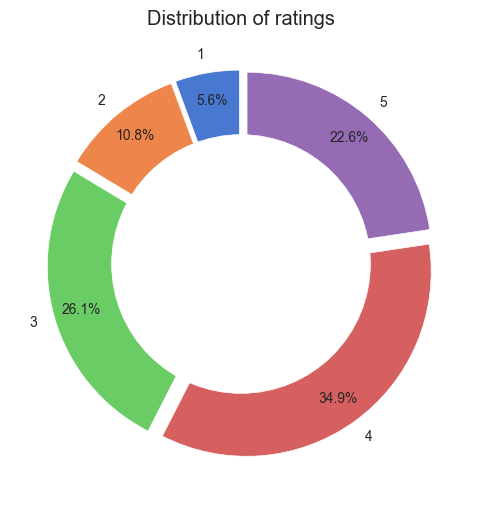

In [55]:

plt.figure(figsize=(15, 6))
data = tmp['rating'].value_counts().sort_index()    
plt.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=[0.05]*5)
plt.title('Distribution of ratings')
circle = plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

 


Most of the ratings can be considered positive, that could be because people tend to rate movies they like.
Let's explore the average rating per movie genre.

(0.0, 5.0)

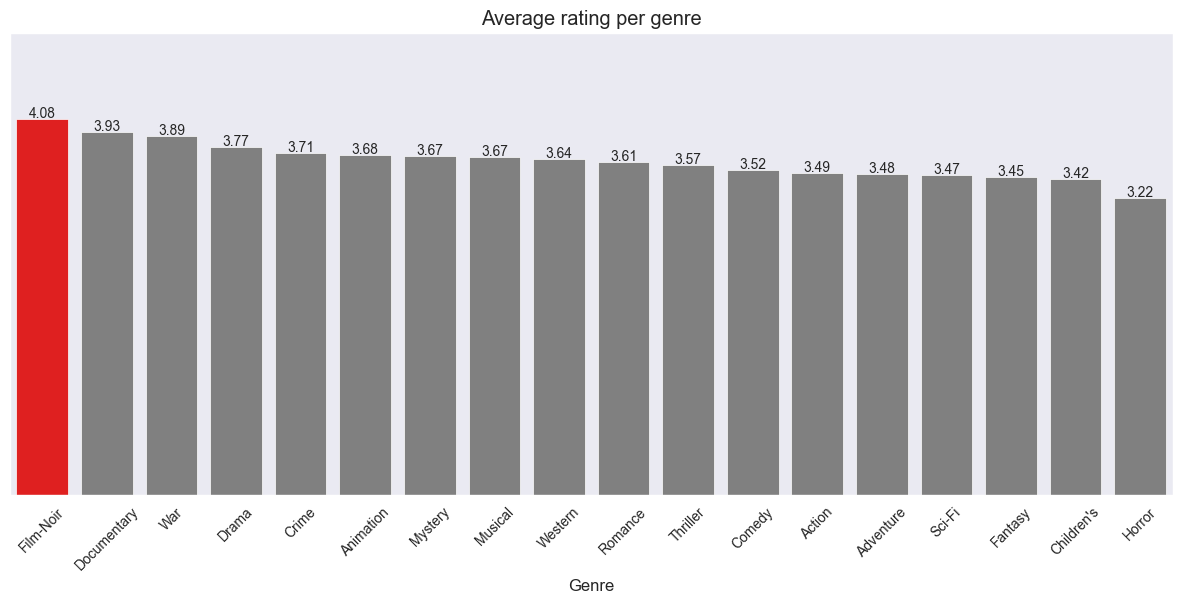

In [56]:
avg_ratings_by_genre = pd.DataFrame(columns=['genre', 'avg_rating'])    
for genre in unique_genres:
    tmp_= tmp[tmp[genre] == 1]
    # print(tmp_)
    avg_ratings_by_genre = pd.concat([avg_ratings_by_genre, pd.DataFrame([[genre, tmp_['rating'].mean()]], columns=['genre', 'avg_rating'])])
avg_ratings_by_genre = avg_ratings_by_genre.sort_values(by='avg_rating', ascending=False)
plt.figure(figsize=(15, 6)) 
colors = ['gray' if (x < max(avg_ratings_by_genre['avg_rating'].values)) else 'red' for x in avg_ratings_by_genre['avg_rating'].values] 
fig = sns.barplot(x='genre', y='avg_rating', data=avg_ratings_by_genre, palette=colors)
plt.title('Average rating per genre')
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+0.01,s='{:.2f}'.format(height), ha='center')
plt.tick_params(labelbottom=True, labelleft=False)
plt.ylabel('')
plt.xlabel('Genre')
plt.xticks(rotation=45);
plt.ylim(0,5)


Film-noir and documentary movies have the highest average rating. Now we are going to look how these average ratings evolved over time.

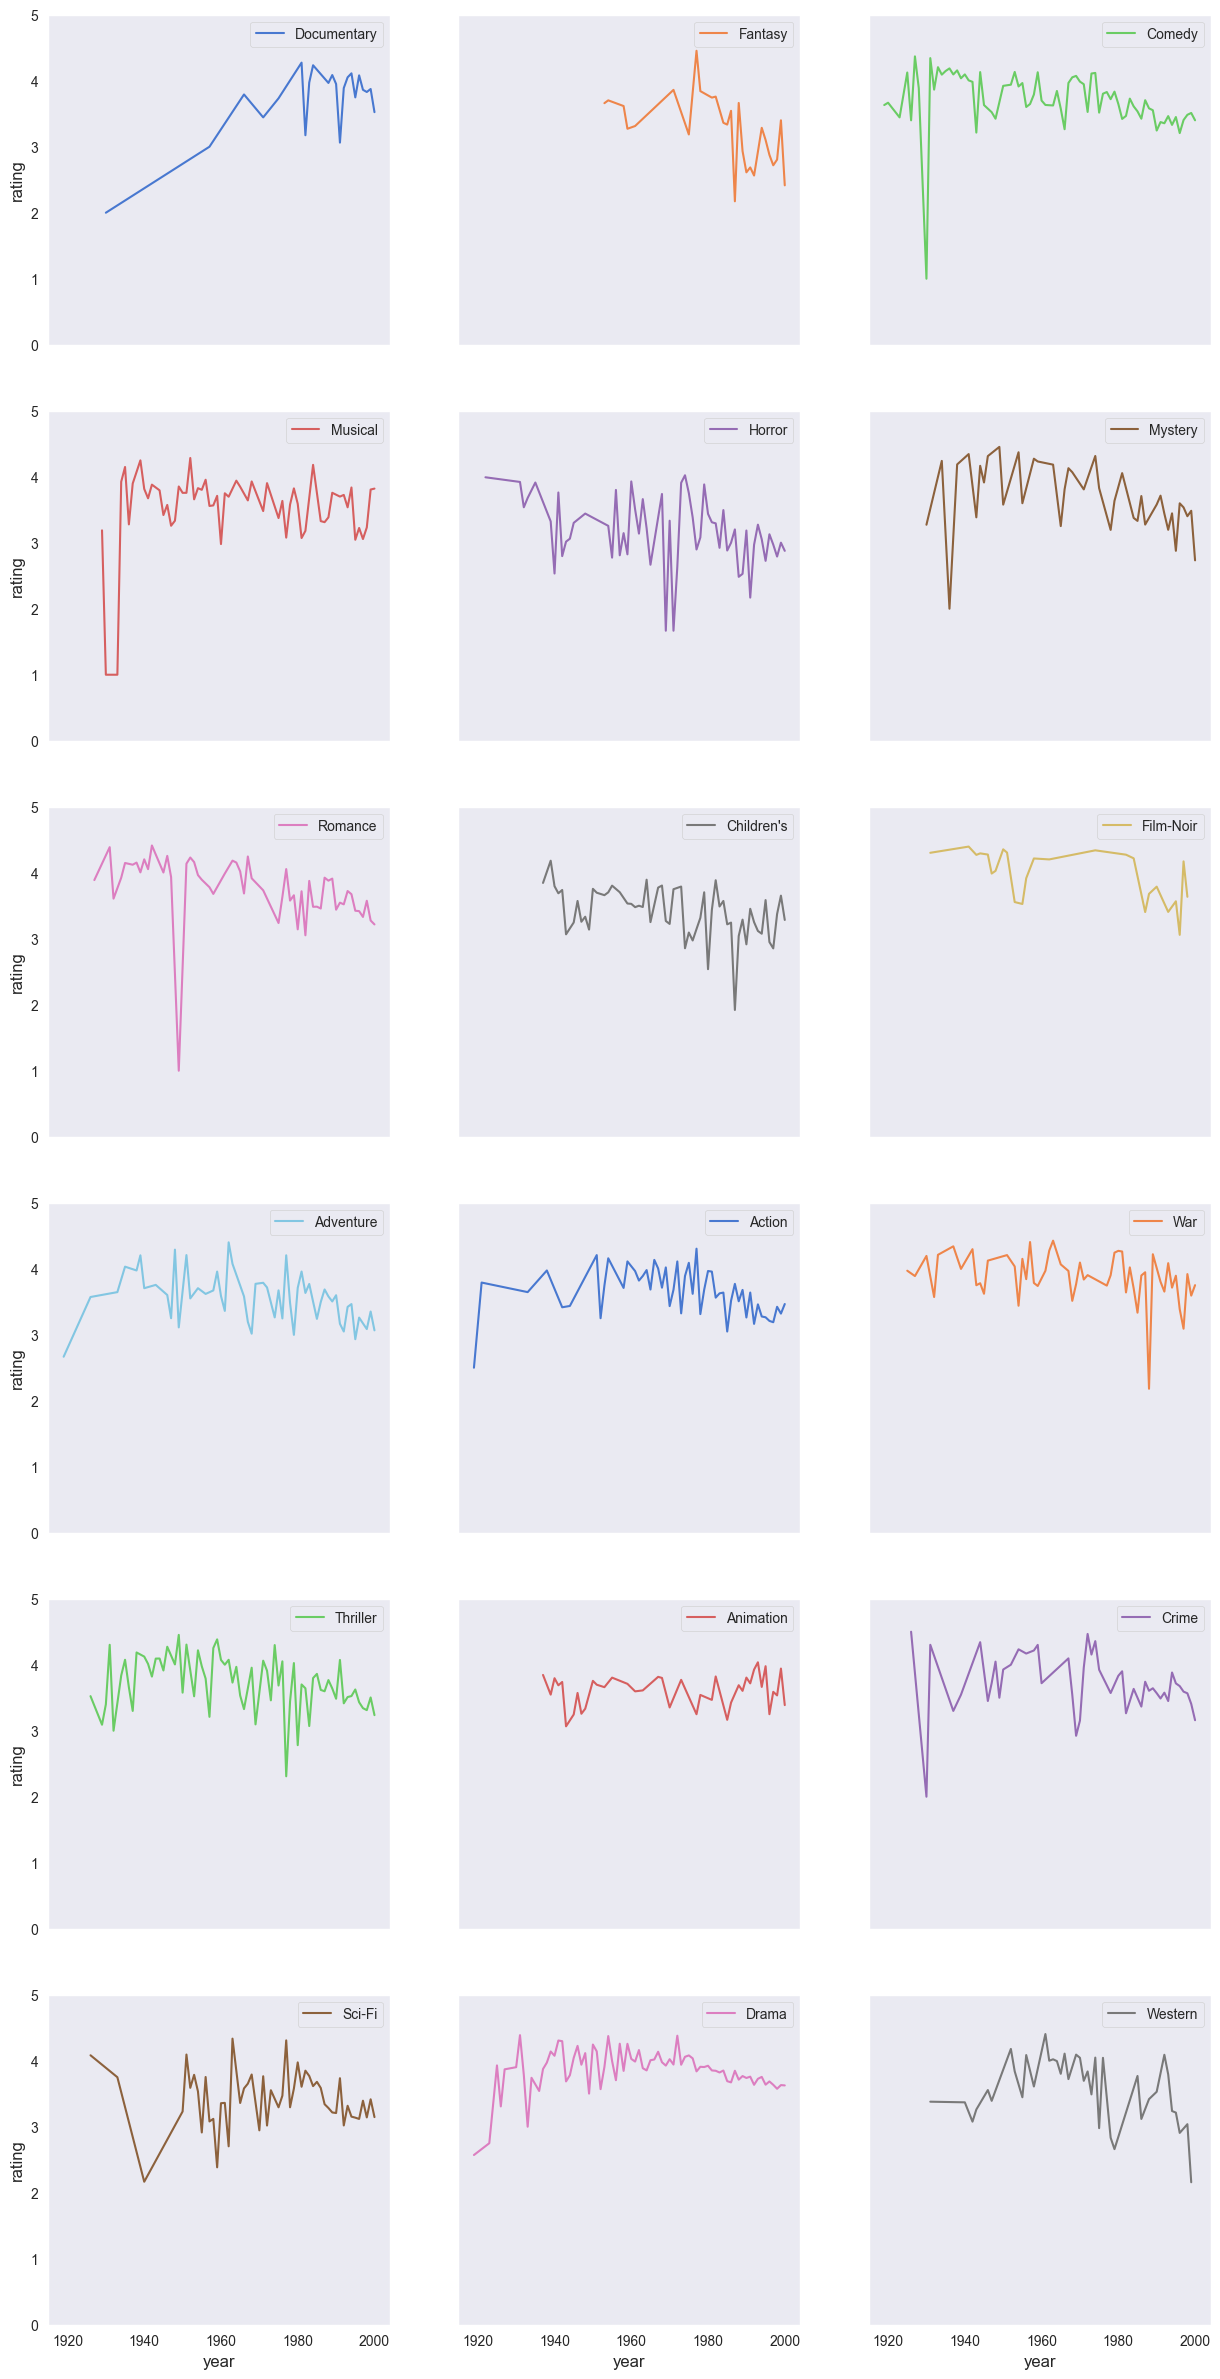

In [57]:
fig, axes = plt.subplots(6, 3, figsize=(15, 30), sharex=True, sharey=True)
plt.ylim(0,5)
colors = sns.color_palette("muted", n_colors=18)
for genre, ax, color in zip(unique_genres, axes.flatten(), colors):
    tmp_ = tmp[tmp[genre] == 1].groupby(['year']).agg({'rating': 'mean'}).reset_index()
    sns.lineplot(data=tmp_, x='year', y='rating', label=genre, ax=ax, color=color)
              

There is no clear trend in the average rating over time.

## Utility Matrix

The utility matrix is a matrix where each row represents a user and each column represents a movie. The values in the matrix are the ratings given by the users to the movies. It is a sparse matrix because most users have not rated most movies.

We are going to split the data into train and test sets. The test set will contain 10% of non-zero ratings.

Some users might only exist in the test set, so we are going to add them to the train set with a rating of 0.

In [58]:
test_ratings = ratings.sample(frac=0.1, random_state=random_seed)

In [59]:
utility_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
print('Percentage of missing values: {:.2f}%'.format(utility_matrix.isnull().sum().sum() / (utility_matrix.shape[0] * utility_matrix.shape[1]) * 100))
utility_matrix

Percentage of missing values: 95.53%


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we fill the missing values with 0.

In [60]:
utility_matrix = utility_matrix.fillna(0)
for index, row in test_ratings.iterrows():
    utility_matrix.loc[row['user_id'], row['movie_id']] = 0

## Model

Let's start by creating a baseline model. The baseline model predicts 3 for every rating.

In [61]:
def baseline_model(matrix):
    return matrix.replace(0,3)

Two additional models are created: one will replace the missing values with the average rating of the movie and the other will replace the missing values with the average rating of the user.

In [62]:
def user_based_model(matrix):
    tmp = matrix[matrix != 0]
    user_mean = tmp.mean(axis=1)
    return matrix.apply(lambda row: row.replace(0, user_mean[row.name]), axis=1)

def item_based_model(matrix):
    tmp = matrix[matrix != 0]
    movie_mean = tmp.mean(axis=0)
    return matrix.apply(lambda col: col.replace(0, movie_mean[col.name]), axis=0)


Now we are going to create a model using non-negative matrix factorization (NMF). NMF is a dimensionality reduction technique that factorizes a matrix into two matrices: one with the users and latent features and the other with the latent features and movies. The dot product of these two matrices approximates the original matrix.
Initially we are going to use 20 latent features.

In [63]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=20, random_state=random_seed)
w_train = nmf.fit_transform(utility_matrix)
h_train = nmf.components_
nmf_train = pd.DataFrame(np.dot(w_train, h_train), index=utility_matrix.index, columns=utility_matrix.columns)
nmf_train[nmf_train > 5] = 5
nmf_train[nmf_train < 1] = 1

c:\Users\cozie\Coding\BBC News Classification\BBC-News-Classification\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Let's see how the model performed on train set

Baseline model error: 2.94
User-based model error: 3.66
Item-based model error: 3.23
NMF model error: 1.10


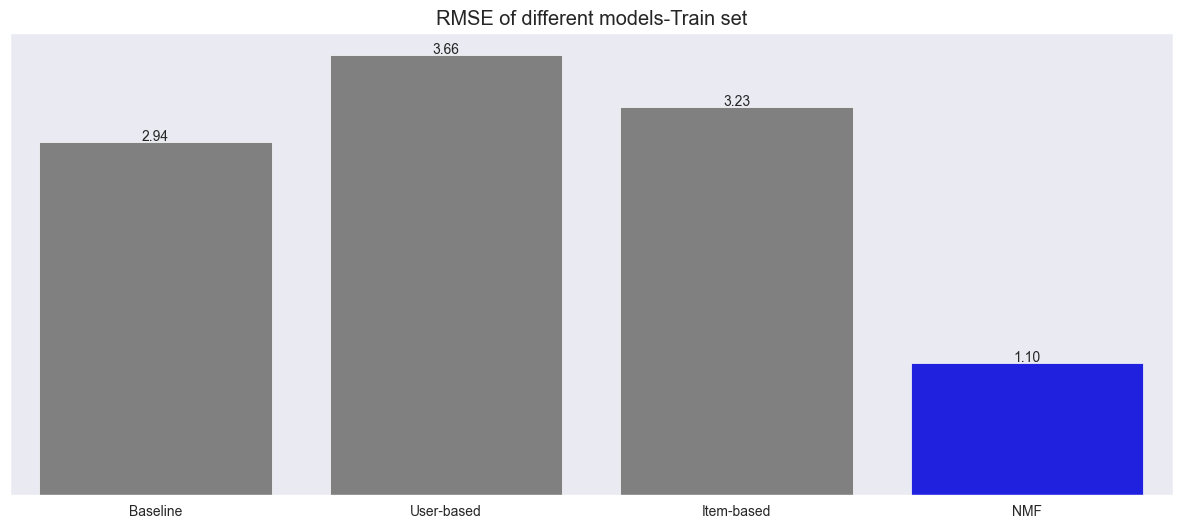

In [64]:
def error(matrix, prediction):
    return np.sqrt(np.mean((matrix-prediction)**2))
baseline_matrix = baseline_model(utility_matrix)
user_based_matrix = user_based_model(utility_matrix)
item_based_matrix = item_based_model(utility_matrix)
baseline_error = error(utility_matrix, baseline_matrix)
user_based_error = error(utility_matrix, user_based_matrix)
item_based_error = error(utility_matrix, item_based_matrix)
nmf_error = error(utility_matrix, nmf_train)

print('Baseline model error: {:.2f}'.format(baseline_error))
print('User-based model error: {:.2f}'.format(user_based_error))
print('Item-based model error: {:.2f}'.format(item_based_error))
print('NMF model error: {:.2f}'.format(nmf_error))

errors = {'Baseline': baseline_error, 'User-based': user_based_error, 'Item-based': item_based_error, 'NMF': nmf_error}
plt.figure(figsize=(15, 6))
colors = ['gray' if (x > min(errors.values())) else 'blue' for x in errors.values()]
fig = sns.barplot(x=list(errors.keys()), y=list(errors.values()), palette=colors)
for patch in fig.patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+0.01,s='{:.2f}'.format(height), ha='center')
plt.title('RMSE of different models-Train set')
plt.tick_params(labelbottom=True, labelleft=False)


Now on test set

In [65]:
for index, row in test_ratings.iterrows():
    test_ratings.loc[index, 'pred_baseline'] = baseline_matrix.loc[row['user_id'], row['movie_id']]
    test_ratings.loc[index, 'pred_user_based'] = user_based_matrix.loc[row['user_id'], row['movie_id']]
    test_ratings.loc[index, 'pred_item_based'] = item_based_matrix.loc[row['user_id'], row['movie_id']]
    test_ratings.loc[index, 'pred_nmf'] = nmf_train.loc[row['user_id'], row['movie_id']]
test_ratings

,user_id,movie_id,rating,timestamp,pred_baseline,pred_user_based,pred_item_based,pred_nmf
324271,1922,2094,4,974694867,3.0,3.468085,3.101669,1.106900
818637,4918,2808,1,963084545,3.0,3.406015,2.524242,1.000000
148677,957,1660,4,975130093,3.0,4.290541,3.544304,1.007101
778790,4653,914,5,975532963,3.0,3.404826,4.164360,1.901086
525489,3245,3324,1,968308411,3.0,2.666667,2.751515,1.000000
...,...,...,...,...,...,...,...,...
720074,4312,1197,4,965483666,3.0,3.267925,4.302103,3.018661
104143,692,1476,4,978374548,3.0,3.829225,3.487859,1.375391
974362,5878,3128,5,1043782706,3.0,3.641026,3.395833,1.000000
639167,3842,2194,3,976515509,3.0,3.704013,4.023881,2.080865


Baseline model error: 1.26
User-based model error: 1.03
Item-based model error: 0.98
NMF model error: 2.37


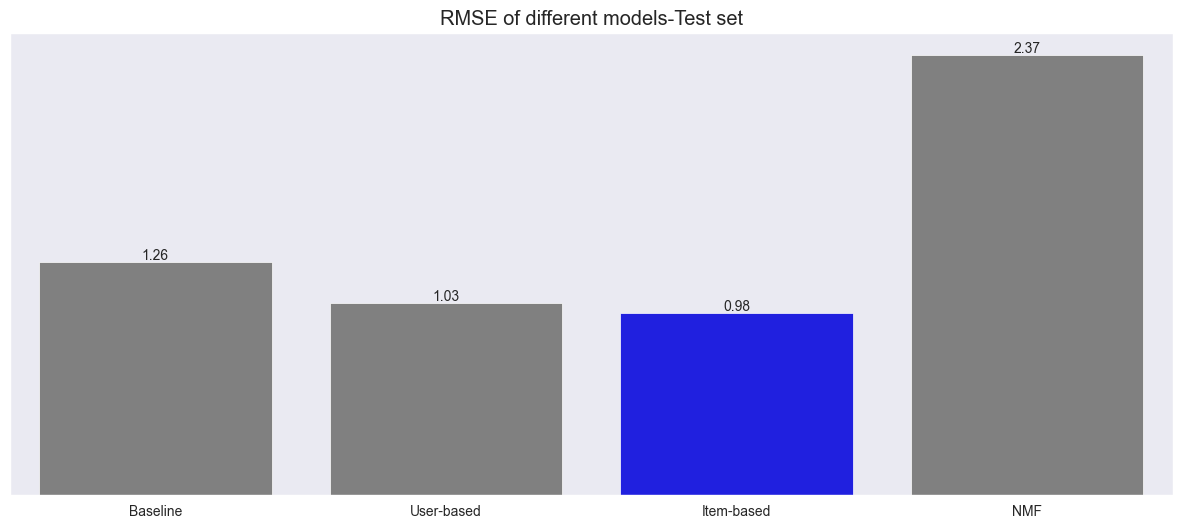

In [66]:
baseline_error = error(test_ratings['rating'], test_ratings['pred_baseline'])
user_based_error = error(test_ratings['rating'], test_ratings['pred_user_based'])
item_based_error = error(test_ratings['rating'], test_ratings['pred_item_based'])
nmf_error = error(test_ratings['rating'], test_ratings['pred_nmf'])

print('Baseline model error: {:.2f}'.format(baseline_error))
print('User-based model error: {:.2f}'.format(user_based_error))
print('Item-based model error: {:.2f}'.format(item_based_error))
print('NMF model error: {:.2f}'.format(nmf_error))

errors = {'Baseline': baseline_error, 'User-based': user_based_error, 'Item-based': item_based_error, 'NMF': nmf_error}
plt.figure(figsize=(15, 6))
colors = ['gray' if (x > min(errors.values())) else 'blue' for x in errors.values()]
fig = sns.barplot(x=list(errors.keys()), y=list(errors.values()), palette=colors)
for patch in fig.patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+0.01,s='{:.2f}'.format(height), ha='center')
plt.title('RMSE of different models-Test set')
plt.tick_params(labelbottom=True, labelleft=False)



For the test set the NMF model is the worst model. Let's try some hyperparameter tuning.

In [67]:
latent_factors = range(0,101,10)[1:]
train_errors = []
test_errors = []
times = []
for k in latent_factors:
    start = time.time()
    print('k = {}'.format(k))
    nmf = NMF(n_components=k, random_state=random_seed, init='random',
              alpha_W=0.01, l1_ratio=0, max_iter=1000)
    w_train = nmf.fit_transform(utility_matrix)
    h_train = nmf.components_
    nmf_train = pd.DataFrame(np.dot(w_train, h_train), index=utility_matrix.index, columns=utility_matrix.columns)
    nmf_train[nmf_train > 5] = 5
    nmf_train[nmf_train < 1] = 1
    train_errors.append(error(utility_matrix, nmf_train))
    preds = []
    for index, row in test_ratings.iterrows():
        preds.append(nmf_train.loc[row['user_id'], row['movie_id']])
    preds = np.array(preds)
    test_errors.append(error(test_ratings['rating'], preds))
    times.append(time.time() - start)
    print('Train error: {:.2f}'.format(train_errors[-1]))
    print('Test error: {:.2f}'.format(test_errors[-1]))
    print('Time: {:.2f}s'.format(times[-1]))
    print('-'*30)

k = 10


Train error: 1.11
Test error: 2.45
Time: 7.31s
------------------------------
k = 20
Train error: 1.10
Test error: 2.41
Time: 23.48s
------------------------------
k = 30
Train error: 1.10
Test error: 2.39
Time: 22.82s
------------------------------
k = 40
Train error: 1.10
Test error: 2.38
Time: 29.60s
------------------------------
k = 50
Train error: 1.10
Test error: 2.38
Time: 50.60s
------------------------------
k = 60
Train error: 1.09
Test error: 2.39
Time: 92.18s
------------------------------
k = 70
Train error: 1.09
Test error: 2.39
Time: 112.11s
------------------------------
k = 80
Train error: 1.09
Test error: 2.39
Time: 94.67s
------------------------------
k = 90
Train error: 1.09
Test error: 2.40
Time: 157.63s
------------------------------
k = 100
Train error: 1.09
Test error: 2.41
Time: 233.10s
------------------------------


Text(0.5, 0, 'k')

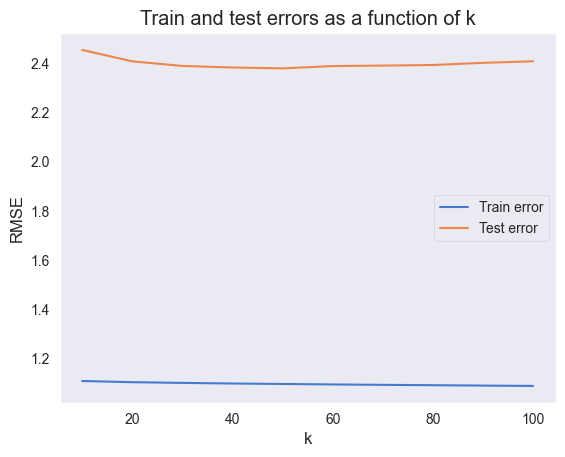

In [68]:
sns.lineplot(x=latent_factors, y=train_errors, label='Train error')
sns.lineplot(x=latent_factors, y=test_errors, label='Test error')
plt.title('Train and test errors as a function of k')
plt.ylabel('RMSE')
plt.xlabel('k')



So the elbow method suggests that the optimal number of latent features is around 20. So we are going to use 20 latent features.

It is important to note that the NMF model is the worst model for the test set, but it is the best model for the train set. That means that the model does not generalize well to unseen data.

A good idea could be to use a hybrid model that combines the NMF model with some other recommendation system like cosine similarity.

In [69]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
# for i, (train_index, test_index) in enumerate(kf.split(ratings)):
#     print(f"Fold {i}:")
#     test_ratings = ratings.iloc[test_index]
#     utility_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')
#     utility_matrix = utility_matrix.fillna(0)
#     for index, row in test_ratings.iterrows():
#         utility_matrix.loc[row['user_id'], row['movie_id']] = 0
#     nmf = NMF(n_components=20, random_state=random_seed)
#     w_train = nmf.fit_transform(utility_matrix)
#     h_train = nmf.components_
#     nmf_train = pd.DataFrame(np.dot(w_train, h_train), index=utility_matrix.index, columns=utility_matrix.columns)
#     for index, row in test_ratings.iterrows():
#         test_ratings.loc[index, 'pred_nmf'] = nmf_train.loc[row['user_id'], row['movie_id']]
#     nmf_error = error(test_ratings['rating'], test_ratings['pred_nmf'])
#     print('NMF model error: {:.2f}'.format(nmf_error))
    
    
    


## Recommendations

Let's train the NMF model with the whole dataset.

In [70]:
data = ratings.pivot(index='user_id', columns='movie_id', values='rating')
data = data.fillna(0)
nmf = NMF(n_components=20, random_state=random_seed, max_iter=1000)
w = nmf.fit_transform(data)
h = nmf.components_
nmf_matrix = pd.DataFrame(np.dot(w, h), index=data.index, columns=data.columns)
nmf_matrix[nmf_matrix > 5] = 5
nmf_matrix[nmf_matrix < 1] = 1

Now we are going to make some recommendations based on the user

In [81]:
ratings[ratings['user_id']==4374].sort_values(by='rating', ascending=False).head(10)

,user_id,movie_id,rating,timestamp
730981,4374,3793,5,965179616
731043,4374,1986,5,965178923
731080,4374,441,5,965178406
731040,4374,1983,5,965178923
731039,4374,1982,5,965178923
731038,4374,47,5,965179301
731081,4374,457,5,965179616
731036,4374,3578,5,965179661
731035,4374,2916,5,965179726
731034,4374,39,5,965178406


In [89]:
def make_recommendation(user_id, nmf_matrix, movies, n_recommendations=10):
    user_ratings = nmf_matrix.loc[user_id]
    user_ratings = user_ratings[user_ratings > 0].sort_values(ascending=False)[:n_recommendations]
    user_ratings = user_ratings.reset_index()
    user_ratings.columns = ['movie_id', 'pred_rating']
    user_ratings = pd.merge(user_ratings, movies, on='movie_id', how='left')
    user_ratings = pd.merge(user_ratings, ratings[ratings['user_id']==user_id], on='movie_id', how='left')
    user_ratings = user_ratings[['movie_id', 'title', 'pred_rating', 'rating']]
    user_ratings.fillna('Not rated', inplace=True)
    return user_ratings
random_user_id = np.random.choice(ratings['user_id'].unique())
print('User id: {}'.format(random_user_id))
top_movie = ratings[ratings['user_id'] == random_user_id].sort_values(by='rating', ascending=False).iloc[0]['movie_id']
print('Top rated movie: {}'.format(movies[movies['movie_id'] == top_movie]['title'].values[0]))
recommendations = make_recommendation(random_user_id, nmf_matrix, movies)
recommendations

User id: 2898
Top rated movie: Life Is Beautiful (La Vita è bella) 


,movie_id,title,pred_rating,rating
0,2858,American Beauty,3.879401,5.0
1,1196,Star Wars: Episode V - The Empire Strikes Back,3.671030,5.0
2,260,Star Wars: Episode IV - A New Hope,3.639760,5.0
3,110,Braveheart,3.432953,Not rated
4,1210,Star Wars: Episode VI - Return of the Jedi,3.425340,Not rated
5,2571,"Matrix, The",3.419835,5.0
6,2762,"Sixth Sense, The",3.417033,4.0
7,3578,Gladiator,3.416102,4.0
8,1198,Raiders of the Lost Ark,3.328977,5.0
9,589,Terminator 2: Judgment Day,3.231365,4.0


Now, if we want to recommend movies based on the movie, we could use the matrix H which contains the latent features and movies. From this matrix we can calculate the cosine similarity between movies and recommend the most similar movies based on the current movie.

In [115]:
from sklearn.metrics.pairwise import cosine_similarity

def recommendations_from_movie(movie_id, similiraty_items, n_recommendations=10):
    movie_similarities = similiraty_items[movie_id].sort_values(ascending=False)[1:n_recommendations+1]
    movie_similarities = movie_similarities.reset_index()
    movie_similarities.columns = ['movie_id', 'similarity']
    movie_similarities = pd.merge(movie_similarities, movies, on='movie_id', how='left')
    return movie_similarities[['movie_id', 'title', 'similarity']]

random_movie = np.random.choice(ratings['movie_id'].unique())
print('Movie id: {}'.format(random_movie))
print('Movie name: {}'.format(movies[movies['movie_id'] == random_movie]['title'].values[0]))
similarities_items = cosine_similarity(h.T)
similarities_items = pd.DataFrame(similarities_items, index=data.columns, columns=data.columns)
recommendations = recommendations_from_movie(random_movie, similarities_items)
recommendations

Movie id: 3878
Movie name: X: The Unknown 


,movie_id,title,similarity
0,2664,Invasion of the Body Snatchers,0.952188
1,3932,"Invisible Man, The",0.946127
2,2660,"Thing From Another World, The",0.938775
3,3486,Devil Girl From Mars,0.911543
4,3931,"Giant Gila Monster, The",0.904390
5,3659,Quatermass II,0.902600
6,3647,Running Free,0.900164
7,2010,Metropolis,0.897563
8,2667,"Mole People, The",0.880040
9,2287,Them!,0.874810


## References

http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/

https://www.jiristodulka.com/post/recsys_cf/

https://arxiv.org/pdf/1401.5226.pdf